In [1]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Flatten, Input
from tensorflow.python.keras.layers import GRU
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
# from keras.wrappers import scikit_learn
# from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from keras.layers import LSTM

import tensorflow as tf
from keras import backend as K

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.05
session = tf.Session(config=config) # Letrehozunk egy TF session-t a megfelelo mem. korlattal
K.set_session(session) # atadjuk azt a Kerasnak

Using TensorFlow backend.


<h3>Loading dataset</h3>

In [2]:
import pandas as pd
import numpy as np

# import csv
df = pd.read_csv('modified_dataset.csv', 
                 dtype={'Temperature':str, 
                        'Pressure0':str, 
                        'Humidity':str, 
                        'Wind_speed':str}, 
                 delimiter=';', 
                 na_filter=False)
print("Sneak peak of the data set:")
df.head()

#excluding the timestamp form the input features and
#setting output to be the temperature of following day

X = np.array(df.loc[:,(df.columns != 'Time')].values)

no_samples= X.shape[0]
print(X.shape[0])

X = X[0:(no_samples-1) , :]
Y = X[1:no_samples , 0]

no_samples = X.shape[0]
print(X.shape[0])

print(Y.shape)
print(X[:,0].shape)

Sneak peak of the data set:
63135
63134
(63133,)
(63134,)


<h3>Preparing input and output sequence</h3>

In [3]:
for idx, val in enumerate(X[:,0]):
    if val=='':
        X[:,0][idx] = (np.float64(X[:,0][idx-1])+np.float64(X[:,0][idx+1]))/2
    else:
        X[:,0][idx] = np.float64(val)
        
for idx, val in enumerate(X[:,1]):
    if val=='':
        X[:,1][idx] = (np.float64(X[:,1][idx-1])+np.float64(X[:,1][idx+1]))/2
    else:
        X[:,1][idx] = np.float64(val)
        

for idx, val in enumerate(X[:,2]):
    if val=='':
        X[:,2][idx] = (int(X[:,2][idx-1])+int(X[:,2][idx+1]))/2
    else:
        X[:,2][idx] = int(val)
        
for idx, val in enumerate(X[:,3]):
    if val=='':
        X[:,3][idx] = (int(X[:,3][idx-1])+int(X[:,3][idx+1]))/2
    else:
        X[:,3][idx] = int(val)
        
for idx, val in enumerate(X[:,4]):
    if val=='':
        X[:,4][idx] = (int(X[:,4][idx-1])+int(X[:,4][idx+1]))/2
    else:
        X[:,4][idx] = int(val)
        
for idx, val in enumerate(Y):
    if val=='':
        Y[idx] = (int(Y[idx-1])+int(Y[idx+1]))/2
    else:
        Y[idx] = int(val)

# print(Y.shape)
# Y2=np.zeros((63132,2), dtype='float64')
# Y2[0:63132, 1] = Y[0:63132]
# Y2[0:63132, 0] = Y[1:63133]

# X2 = X[1:63133,:]

# X=X2
# Y=Y2

<h3>Preprocessing data</h3>

In [4]:
nb_samples = len(X)
test_split = 0.2

# splitting train-validation-test sets
X_train = X[0:int(nb_samples*(1-test_split))].astype(np.float32)
Y_train = Y[0:int(nb_samples*(1-test_split))].astype(np.float32)
X_test  = X[int(nb_samples*(1-test_split)):].astype(np.float32)
Y_test  = Y[int(nb_samples*(1-test_split)):].astype(np.float32)

print("train set dims:")
print(X_train.shape)
print(Y_train.shape)
print("test set dims:")
print(X_test.shape)
print(Y_test.shape)

#tsandardizing
print('\nmean of X_train')
print(np.mean(X_train,0))
print('\nstd dev of X_train')
print(np.std(X_train, 0))

#mean
atl0= np.mean(X_train, axis=0)
X_train -= np.expand_dims(atl0, 0)
X_test  -= np.expand_dims(atl0, 0)

#std
std0 = np.std(X_train, axis=0)
X_train /= np.expand_dims(std0,0)
X_test  /= np.expand_dims(std0,0)

train set dims:
(50507, 40)
(50507,)
test set dims:
(12627, 40)
(12626,)

mean of X_train
[1.03969154e+01 7.49434265e+02 7.62776489e+02 7.58260422e+01
 3.38511491e+00 1.31823316e-01 7.50193059e-01 2.31057089e-02
 8.52753073e-02 5.28243594e-02 2.09079925e-02 1.00778108e-02
 8.71166354e-04 8.83045886e-03 1.38594653e-04 5.93977056e-05
 8.85817781e-02 3.72423641e-02 4.25485559e-02 3.47674564e-02
 3.62326019e-02 2.09673904e-02 1.46514345e-02 5.57744466e-02
 8.14144537e-02 4.23109680e-02 2.37194840e-02 2.16405652e-02
 3.26291397e-02 3.32627147e-02 2.55588323e-01 5.34975342e-02
 9.62836817e-02 2.88276877e-02 7.62270577e-03 9.27792192e-02
 1.25249967e-01 5.81939161e-01 6.42881170e-02 1.28120854e-01]

std dev of X_train
[9.7300119e+00 5.9500389e+00 6.1738591e+00 2.0032175e+01 2.1750498e+00
 3.3829856e-01 4.3290120e-01 1.5023926e-01 2.7929094e-01 2.2368269e-01
 1.4307638e-01 9.9881172e-02 2.9502671e-02 9.3554698e-02 1.1771806e-02
 7.7067614e-03 2.8413913e-01 1.8935513e-01 2.0183702e-01 1.8319029

<h3>Loss function definition</h3>

In [5]:
import keras.backend as K

def patkolt_loss(x0, alpha = 0.0):
    def vori(y_true, y_pred):
        constr = K.maximum(K.abs(y_pred- (x0*std0[0] +atl0[0])) - 12.0 ,
                           0.0)
        mse = K.square(y_pred-y_true)
        return(K.mean(mse + alpha*constr))
    
    return vori

<h3>Model definition</h3>

In [6]:
adam=Adam(lr=0.001, 
          beta_1=0.9, 
          beta_2=0.999, 
          epsilon=None, 
          decay=0.0, 
          amsgrad=False)

def model(alfa = 0.0):
    def modelfn():
        bem = Input(shape=(40,), dtype='float32')
        kim = Dense(10, activation='relu')(bem)
        kim = Dense(4, activation='relu')(kim)
        kim = Dense(1, activation='relu')(kim)
        model= Model(bem, kim)
        model.compile(loss = patkolt_loss(bem[:,0]), 
                      optimizer = adam, 
                      metrics = ['mse', patkolt_loss(bem[:,0], alpha= alfa)])
        print(model.summary())
        return model
    return modelfn()

Instructions for updating:
Colocations handled automatically by placer.


<h3> Training </h3>

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              min_delta=0, 
                              patience=5, 
                              verbose=0, 
                              mode='auto', 
                              baseline=None, 
                              restore_best_weights=True)

print("msemodel")
msemodel = model(alfa = 0.0)
msehst = msemodel.fit(X_train[:,:], 
                      Y_train[:], 
                      verbose=1, 
                      batch_size=16, 
                      epochs=35, 
                      validation_split=0.1, 
                      callbacks = [early_stopping])

print('\nctrmodel')
ctrmodel = model(alfa = 1.0)
ctrhst = ctrmodel.fit(X_train[:,:], 
                      Y_train[:], 
                      verbose=1, 
                      batch_size=16, 
                      epochs=35, 
                      validation_split=0.1, 
                      callbacks = [early_stopping])

print('\nalphamodel')
alphamodel = model(alfa=0.5)
alphahst = alphamodel.fit(X_train[:,:], 
                          Y_train[:], 
                          verbose=1, 
                          batch_size=16, 
                          epochs=35, 
                          validation_split=0.1, 
                          callbacks = [early_stopping])

msemodel
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                410       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 459
Trainable params: 459
Non-trainable params: 0
_________________________________________________________________
None
Train on 45456 samples, validate on 5051 samples
Epoch 1/35
45456/45456 [==============================] - 3s 74us/step - loss: 30.9089 - mean_squared_error: 30.9089 - vori: 30.9089 - val_loss: 6.8433 - val_mean_squared_error: 6.8433 - val_vori: 6.8433
Epoch 2/3

45456/45456 [==============================] - 3s 72us/step - loss: 4.5276 - mean_squared_error: 4.5276 - vori: 6.9664 - val_loss: 5.9481 - val_mean_squared_error: 5.9481 - val_vori: 5.9486
Epoch 5/35
45456/45456 [==============================] - 4s 77us/step - loss: 4.4928 - mean_squared_error: 4.4928 - vori: 6.9147 - val_loss: 5.9194 - val_mean_squared_error: 5.9194 - val_vori: 5.9198
Epoch 6/35
45456/45456 [==============================] - 3s 68us/step - loss: 4.4677 - mean_squared_error: 4.4677 - vori: 6.8929 - val_loss: 5.9154 - val_mean_squared_error: 5.9154 - val_vori: 5.9161
Epoch 7/35
45456/45456 [==============================] - 2s 52us/step - loss: 4.4525 - mean_squared_error: 4.4525 - vori: 6.8865 - val_loss: 5.9160 - val_mean_squared_error: 5.9160 - val_vori: 5.9164
Epoch 8/35
45456/45456 [==============================] - 3s 59us/step - loss: 4.4410 - mean_squared_error: 4.4410 - vori: 6.8723 - val_loss: 5.8986 - val_mean_squared_error: 5.8986 - val_vori: 5.8992
Epoch 

45456/45456 [==============================] - 3s 65us/step - loss: 4.4212 - mean_squared_error: 4.4212 - vori: 5.6322 - val_loss: 5.8890 - val_mean_squared_error: 5.8890 - val_vori: 5.8891
Epoch 28/35
45456/45456 [==============================] - 3s 57us/step - loss: 4.4191 - mean_squared_error: 4.4191 - vori: 5.6255 - val_loss: 5.8544 - val_mean_squared_error: 5.8544 - val_vori: 5.8545
Epoch 29/35
45456/45456 [==============================] - 3s 58us/step - loss: 4.4153 - mean_squared_error: 4.4153 - vori: 5.6242 - val_loss: 5.8498 - val_mean_squared_error: 5.8498 - val_vori: 5.8500
Epoch 30/35
45456/45456 [==============================] - 3s 57us/step - loss: 4.4012 - mean_squared_error: 4.4012 - vori: 5.6109 - val_loss: 5.8606 - val_mean_squared_error: 5.8606 - val_vori: 5.8607


msemodel training  and validation metrics


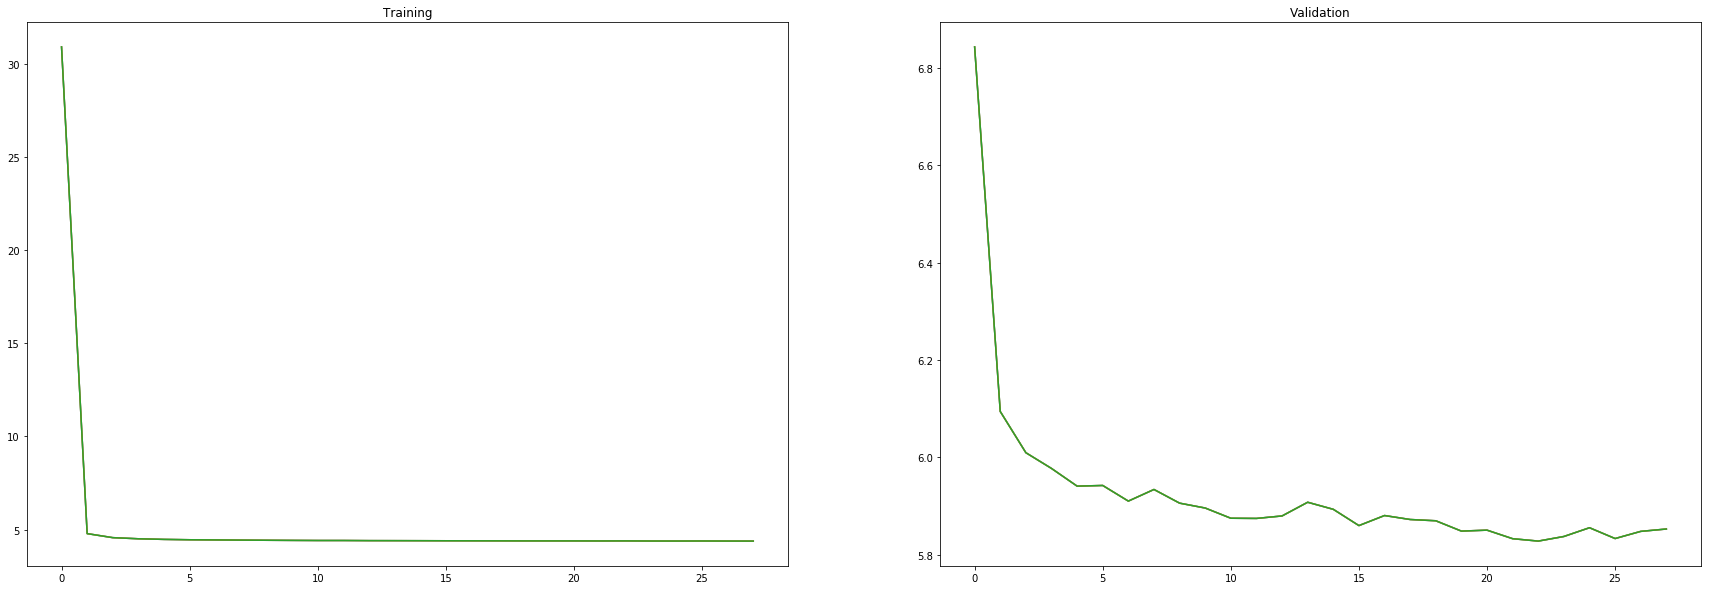

ctrmodel training and validation metrics


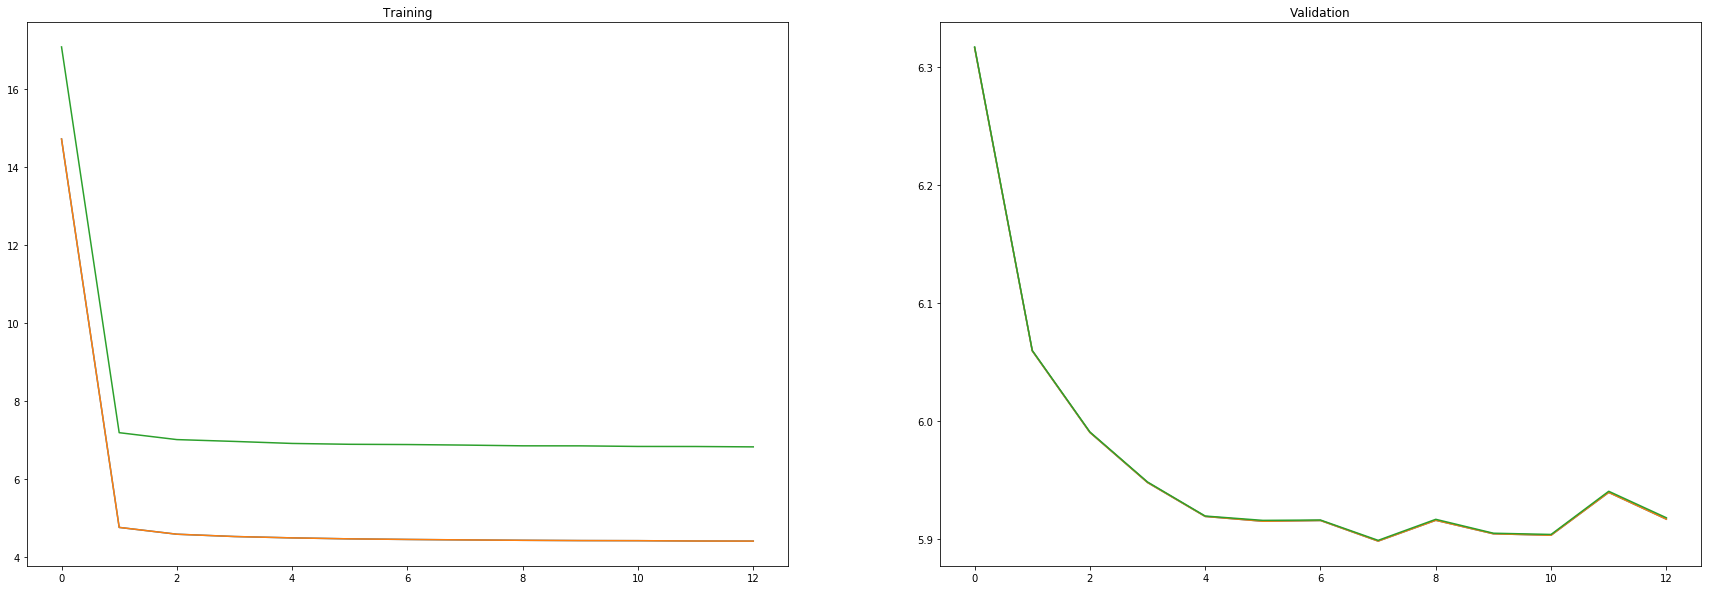

alphamodel training and validation metrics


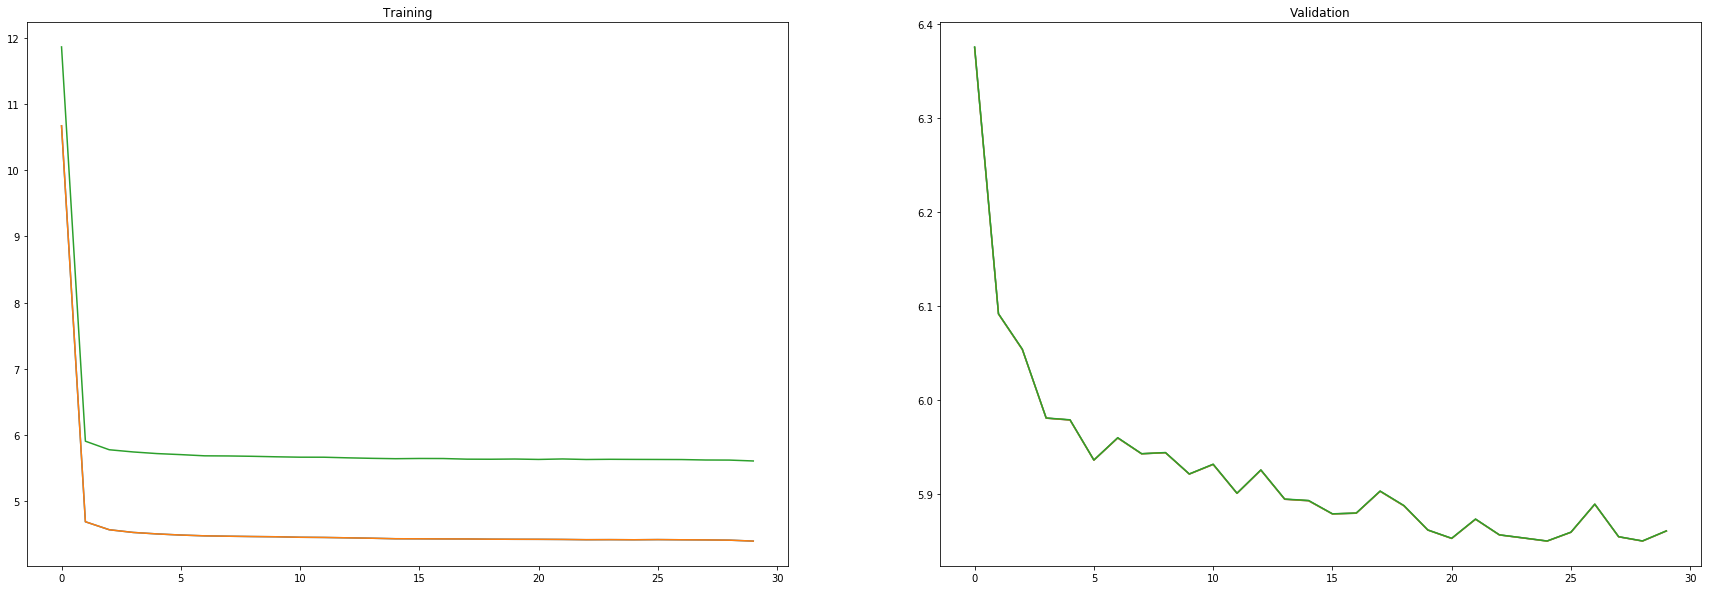

In [8]:
print("msemodel training  and validation metrics")
fig=plt.figure(figsize=(30, 10))
fig.add_subplot(1, 2, 1)
plt.title('Training')
plt.plot(msehst.history['loss'])
plt.plot(msehst.history['mean_squared_error'])
plt.plot(msehst.history['vori'])

fig.add_subplot(1, 2 ,2)
plt.title("Validation")
plt.plot(msehst.history['val_loss'])
plt.plot(msehst.history['val_mean_squared_error'])
plt.plot(msehst.history['val_vori'])
plt.show()

print("ctrmodel training and validation metrics")
fig=plt.figure(figsize=(30, 10))
fig.add_subplot(1, 2, 1)
plt.title('Training')
plt.plot(ctrhst.history['loss'])
plt.plot(ctrhst.history['mean_squared_error'])
plt.plot(ctrhst.history['vori'])

fig.add_subplot(1, 2 ,2)
plt.title("Validation")
plt.plot(ctrhst.history['val_loss'])
plt.plot(ctrhst.history['val_mean_squared_error'])
plt.plot(ctrhst.history['val_vori'])
plt.show()

print("alphamodel training and validation metrics")
fig=plt.figure(figsize=(30, 10))
fig.add_subplot(1, 2, 1)
plt.title('Training')
plt.plot(alphahst.history['loss'])
plt.plot(alphahst.history['mean_squared_error'])
plt.plot(alphahst.history['vori'])

fig.add_subplot(1, 2 ,2)
plt.title("Validation")
plt.plot(alphahst.history['val_loss'])
plt.plot(alphahst.history['val_mean_squared_error'])
plt.plot(alphahst.history['val_vori'])
plt.show()

<h3>Predicting</h3>

In [9]:
msepred=msemodel.predict(X_test)
ctrpred=ctrmodel.predict(X_test)
alphapred=alphamodel.predict(X_test)

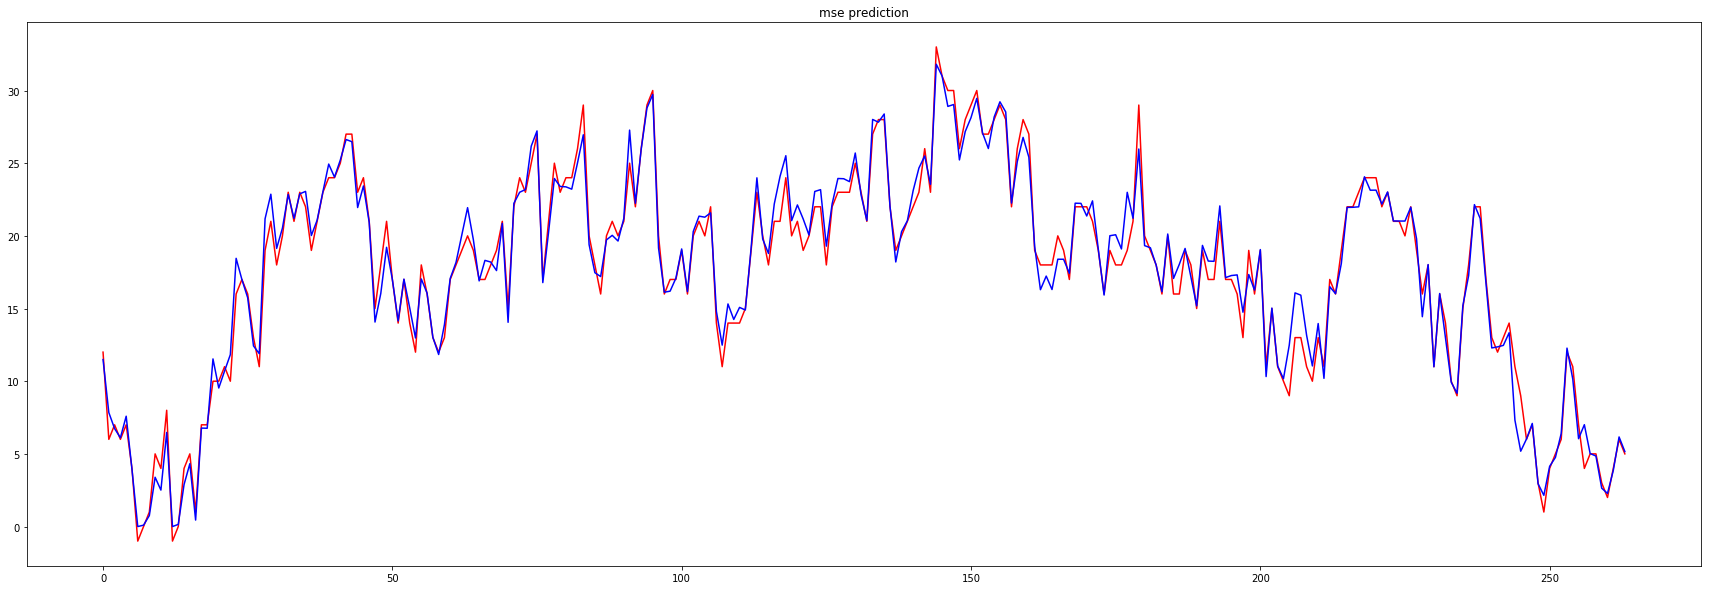

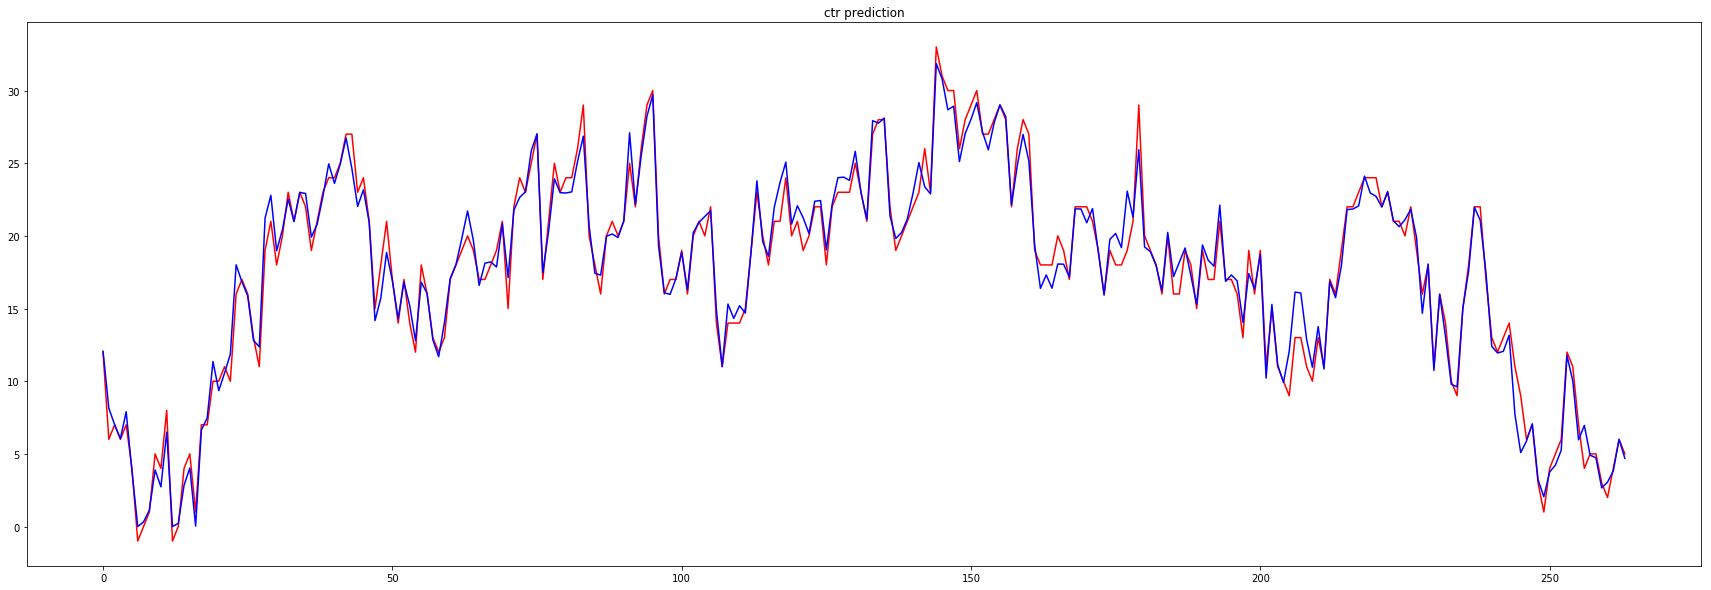

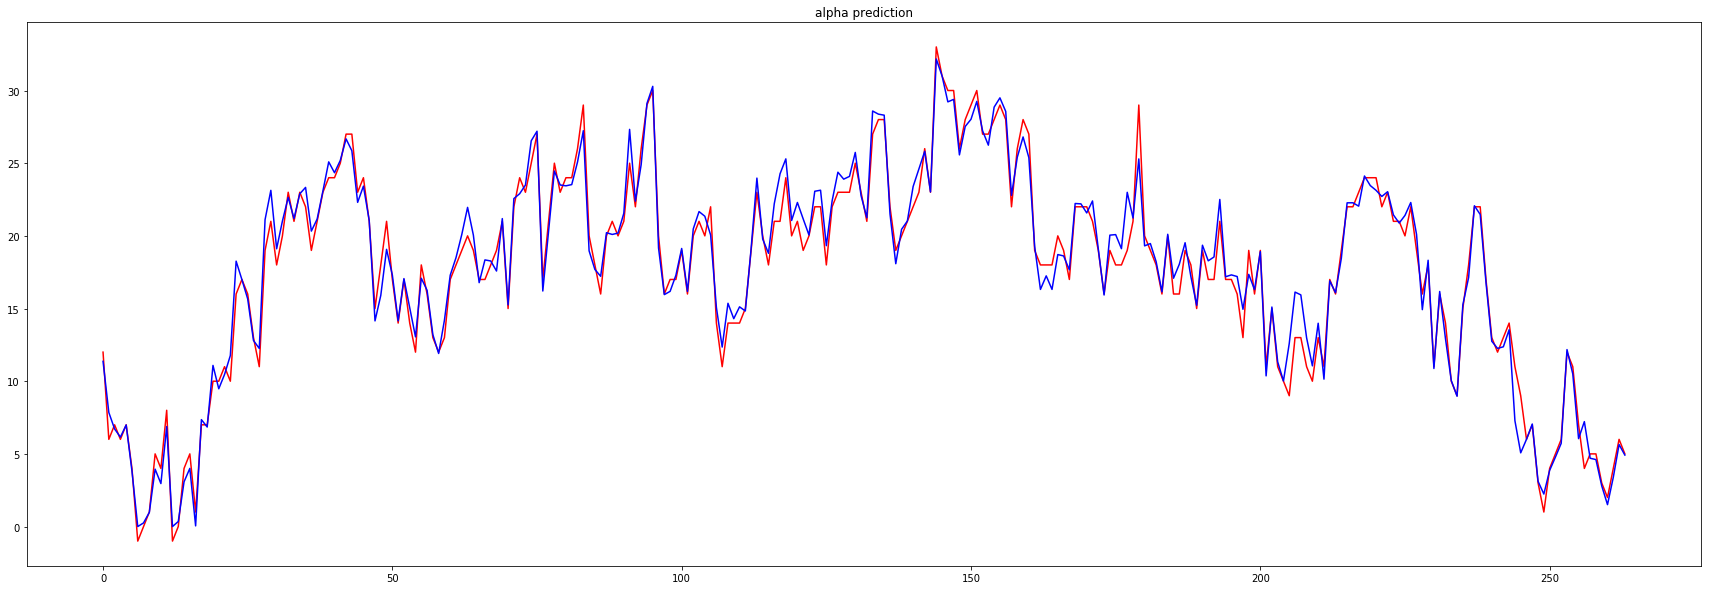

In [10]:
fig=plt.figure(figsize=(30, 10))
plt.plot(Y_test[::48], color='red')
plt.plot(msepred[::48], color='blue')
plt.title('mse prediction')
plt.show()

fig=plt.figure(figsize=(30, 10))
plt.plot(Y_test[::48], color='red')
plt.plot(ctrpred[::48], color='blue')
plt.title('ctr prediction')
plt.show()

fig=plt.figure(figsize=(30, 10))
plt.plot(Y_test[::48], color='red')
plt.plot(alphapred[::48], color='blue')
plt.title('alpha prediction')
plt.show()

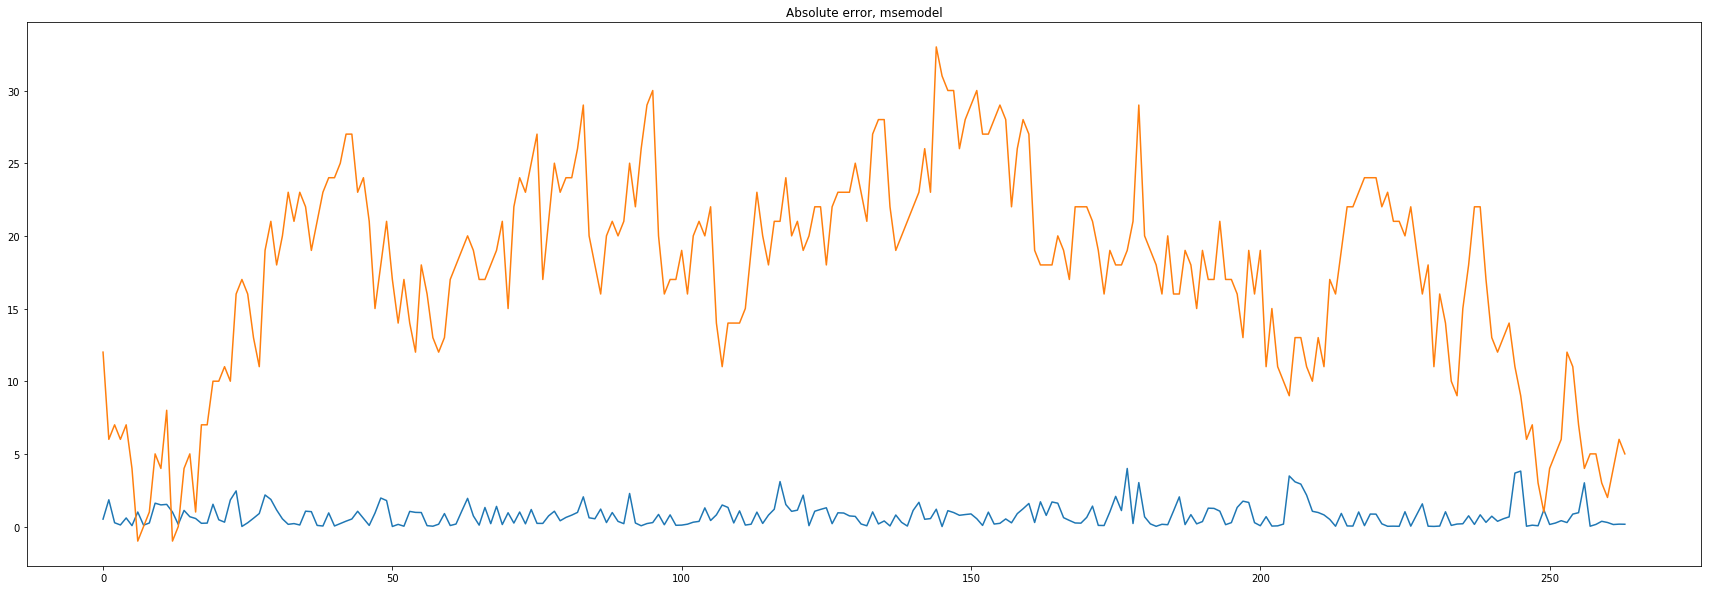

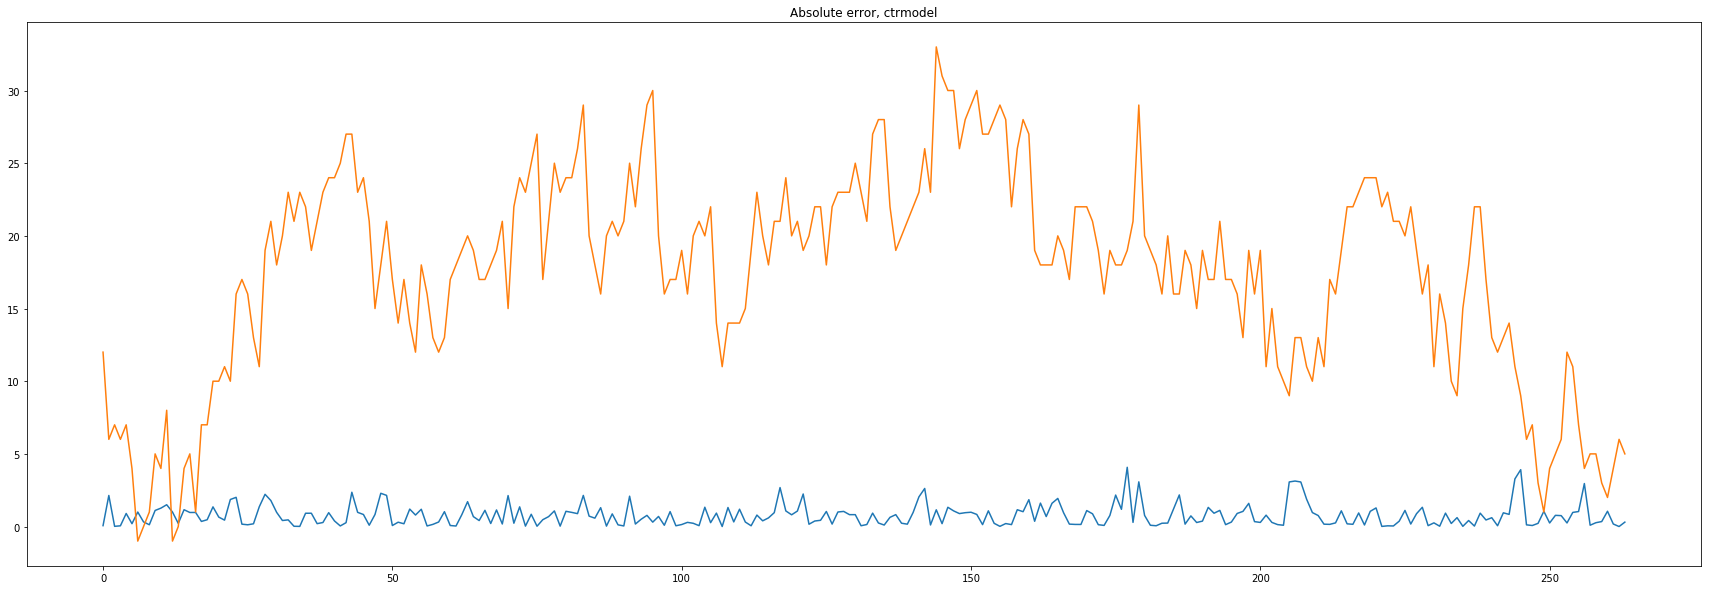

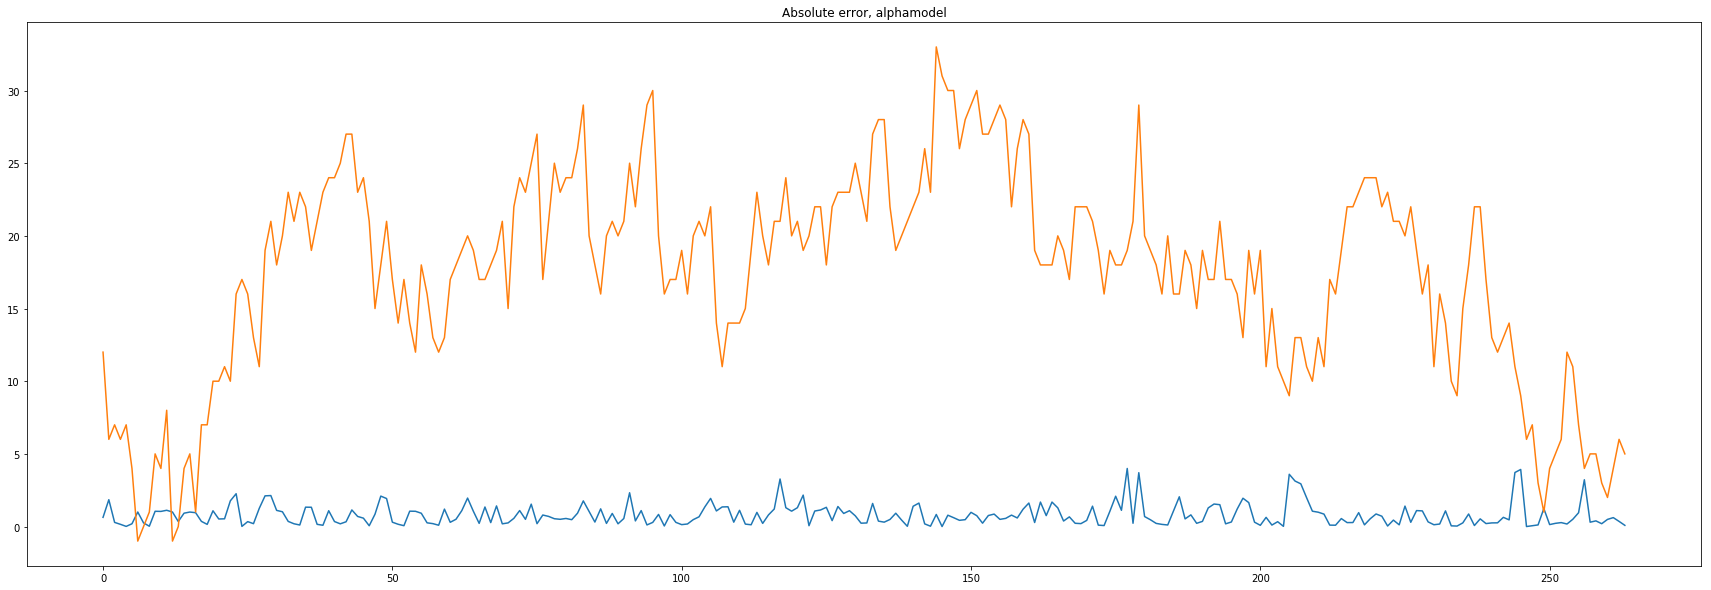

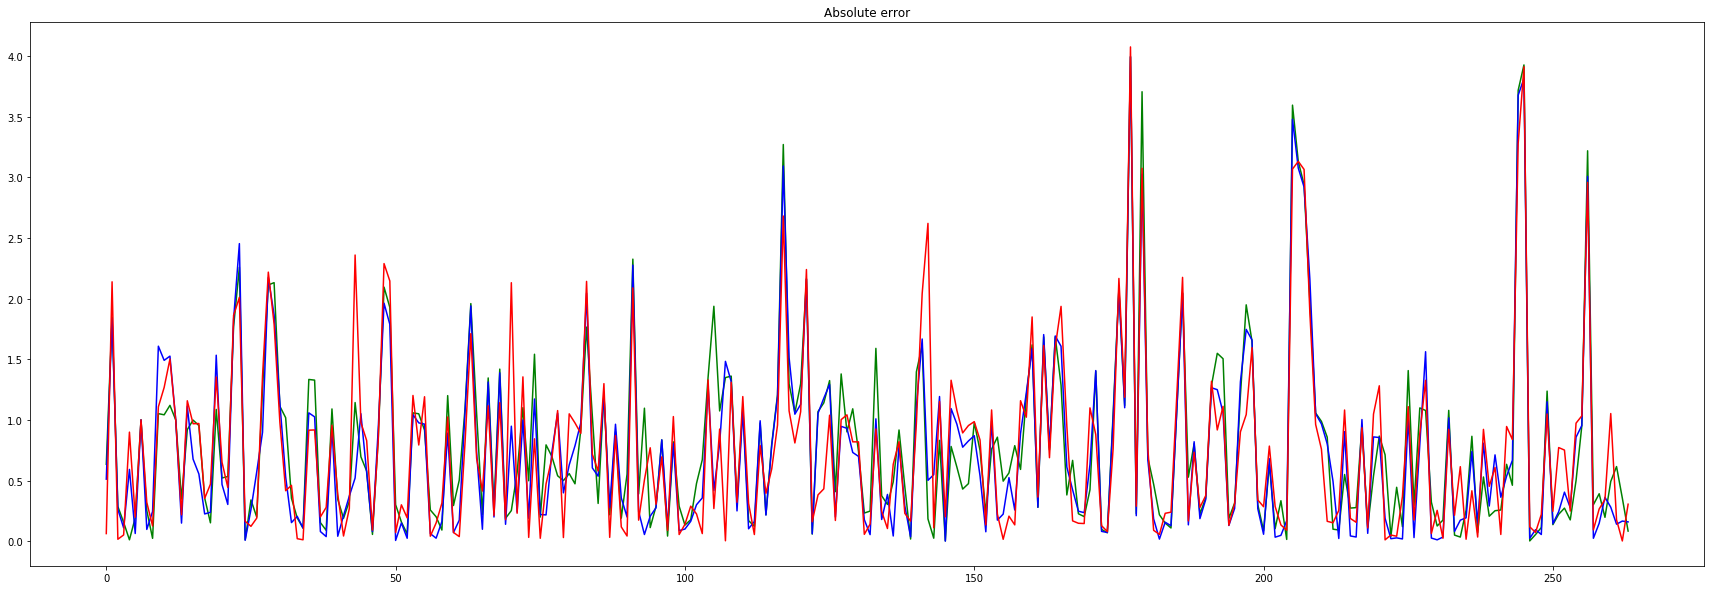

In [11]:
mseabs = []
for i in range(len(Y_test)):
    mseabs.append(abs(msepred[i] - Y_test[i]))
fig=plt.figure(figsize=(30, 10))
plt.plot(mseabs[::48])
plt.plot(Y_test[::48])
plt.title('Absolute error, msemodel')
plt.show()

ctrabs = []
for i in range(len(Y_test)):
    ctrabs.append(abs(ctrpred[i] - Y_test[i]))
fig=plt.figure(figsize=(30, 10))
plt.plot(ctrabs[::48])
plt.plot(Y_test[::48])
plt.title('Absolute error, ctrmodel')
plt.show()

alphaabs = []
for i in range(len(Y_test)):
    alphaabs.append(abs(alphapred[i] - Y_test[i]))
fig=plt.figure(figsize=(30, 10))
plt.plot(alphaabs[::48])
plt.plot(Y_test[::48])
plt.title('Absolute error, alphamodel')
plt.show()

fig=plt.figure(figsize=(30, 10))
plt.title('Absolute error')
plt.plot(alphaabs[::48], color='green')
plt.plot(mseabs[::48], color = 'blue')
plt.plot(ctrabs[::48], color ='red')